In [57]:
import os
import random
import math
import sys

sys.path.append(
    os.path.dirname(os.getcwd())
)

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
from PIL import Image

from src.utils.utils import project_path

train_dir = os.path.join(project_path(), "data")
test_dir = os.path.join(project_path(), "data")

train_images_path = os.path.join(train_dir, "train")
test_images_path = os.path.join(test_dir, "test")

train_classes = [f for f in os.listdir(train_images_path) if os.path.isdir(os.path.join(train_images_path, f))]

In [63]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def correct_and_save(image_path, save_path):
    img = cv2.imread(image_path)
    print(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)
    angles = []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            angle = theta * 180 / np.pi
            angles.append(angle)
    
    corrected_angles = [a - 180 if a > 90 else a for a in angles]
    mean_angle = np.median(corrected_angles)

    rotated = rotate_image(img, -mean_angle)

    cv2.imwrite(save_path, rotated)
    return mean_angle

In [105]:
def estimate_and_save_pca_rotation(image_path, save_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"[ERROR] image load failed! {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_contours = [cnt for cnt in contours if len(cnt) >= 5]
    if not valid_contours:
        vis_img = img.copy()
        conbined = np.hstack((img, vis_img))
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        cv2.imwrite(save_path, conbined)
        print(f"[SKIP] No valid contours: {image_path}")
        return None
        
    all_pts = np.concatenate([cnt.reshape(-1, 2) for cnt in valid_contours])
    all_pts = all_pts.astype(np.float32)
    
    if all_pts.shape[0] < 5:
        print(f"[SKIP] : {image_path}")
        return None

    mean, eigenvectors = cv2.PCACompute(all_pts, mean=np.array([]))
    angle_rad = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
    angle_deg = angle_rad * 180.0 / np.pi

    h, w = img.shape[:2]
    center = tuple(mean[0])
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
    rotated_img = cv2.warpAffine(img, M, (w, h), flags = cv2.INTER_LINEAR, borderValue=(255, 255, 255))

    combined = np.hstack((img, rotated_img))

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cv2.imwrite(save_path, combined)
    print(f"[SAVE] {save_path} (angle: {angle_deg:.2f}°)")

    return angle_deg

In [107]:
# save_root_path = os.path.join(project_path(), 'data', 'train_rotated')
# for class_name in train_classes:
#     class_path = os.path.join(train_images_path, class_name)
#     save_rotated_path = os.path.join(save_root_path, class_name)

#     os.makedirs(save_rotated_path, exist_ok=True)

#     for img_name in os.listdir(class_path):
#         img_path = os.path.join(class_path, img_name)
#         save_img_path = os.path.join(save_rotated_path, img_name)
#         mean_angle = estimate_and_save_pca_rotation(img_path, save_img_path)


In [110]:
def calculate_blur(img_np):
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def calculate_brightness(img_np):
    hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
    return hsv[:, :, 2].mean()

def calculate_contrast(img_np):
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return gray.std()

In [111]:
train_image_data = []
test_image_data = []

for class_name in train_classes:
    class_path = os.path.join(train_images_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                arr = np.array(img)
                h, w, c = arr.shape
                train_image_data.append({
                    "filename": img_name,
                    "class": class_name,
                    "width": w,
                    "height": h,
                    "mean_r": arr[:, :, 0].mean(),
                    "mean_g": arr[:, :, 1].mean(),
                    "mean_b": arr[:, :, 2].mean(),
                    "std_r": arr[:, :, 0].std(),
                    "std_g": arr[:, :, 1].std(),
                    "std_b": arr[:, :, 2].std(),
                    "blur": calculate_blur(arr),
                    "brightness": calculate_brightness(arr),
                    "contrast": calculate_contrast(arr),
                    "type": "train"
                })
        except Exception as e:
            continue

for img_name in os.listdir(test_images_path):
    img_path = os.path.join(test_images_path, img_name)
    try:
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            arr = np.array(img)
            h, w, c = arr.shape
            test_image_data.append({
                "filename": img_name,
                "class": "test",
                "width": w,
                "height": h,
                "mean_r": arr[:, :, 0].mean(),
                "mean_g": arr[:, :, 1].mean(),
                "mean_b": arr[:, :, 2].mean(),
                "std_r": arr[:, :, 0].std(),
                "std_g": arr[:, :, 1].std(),
                "std_b": arr[:, :, 2].std(),
                "blur": calculate_blur(arr),
                "brightness": calculate_brightness(arr),
                "contrast": calculate_contrast(arr),
                "type": "test"
            })
    except Exception as e:
        continue

train_df = pd.DataFrame(train_image_data)
test_df = pd.DataFrame(test_image_data)

In [112]:
train_df.to_csv(os.path.join(project_path(), "data", "train_eda.csv"), index=False)
test_df.to_csv(os.path.join(project_path(), "data", "test_eda.csv"), index=False)

In [113]:
all_df = pd.concat([train_df, test_df], ignore_index=True)

In [114]:
all_df.head(1)

,filename,class,width,height,mean_r,mean_g,mean_b,std_r,std_g,std_b,blur,brightness,contrast,type
0,파일럿_3세대_2016_2018_0070.jpg,파일럿_3세대_2016_2018,546,462,77.725188,77.526723,78.482264,86.037604,85.077748,83.940689,2787.875393,80.078612,85.219397,train


In [41]:
train_df.head(1)

,filename,class,width,height,mean_r,mean_g,mean_b,std_r,std_g,std_b,type
0,파일럿_3세대_2016_2018_0070.jpg,파일럿_3세대_2016_2018,546,462,77.725188,77.526723,78.482264,86.037604,85.077748,83.940689,train


In [42]:
test_df.head(1)

,filename,class,width,height,mean_r,mean_g,mean_b,std_r,std_g,std_b,type
0,TEST_07613.jpg,test,512,382,86.433716,90.78872,93.278489,73.422665,73.858179,74.644351,test


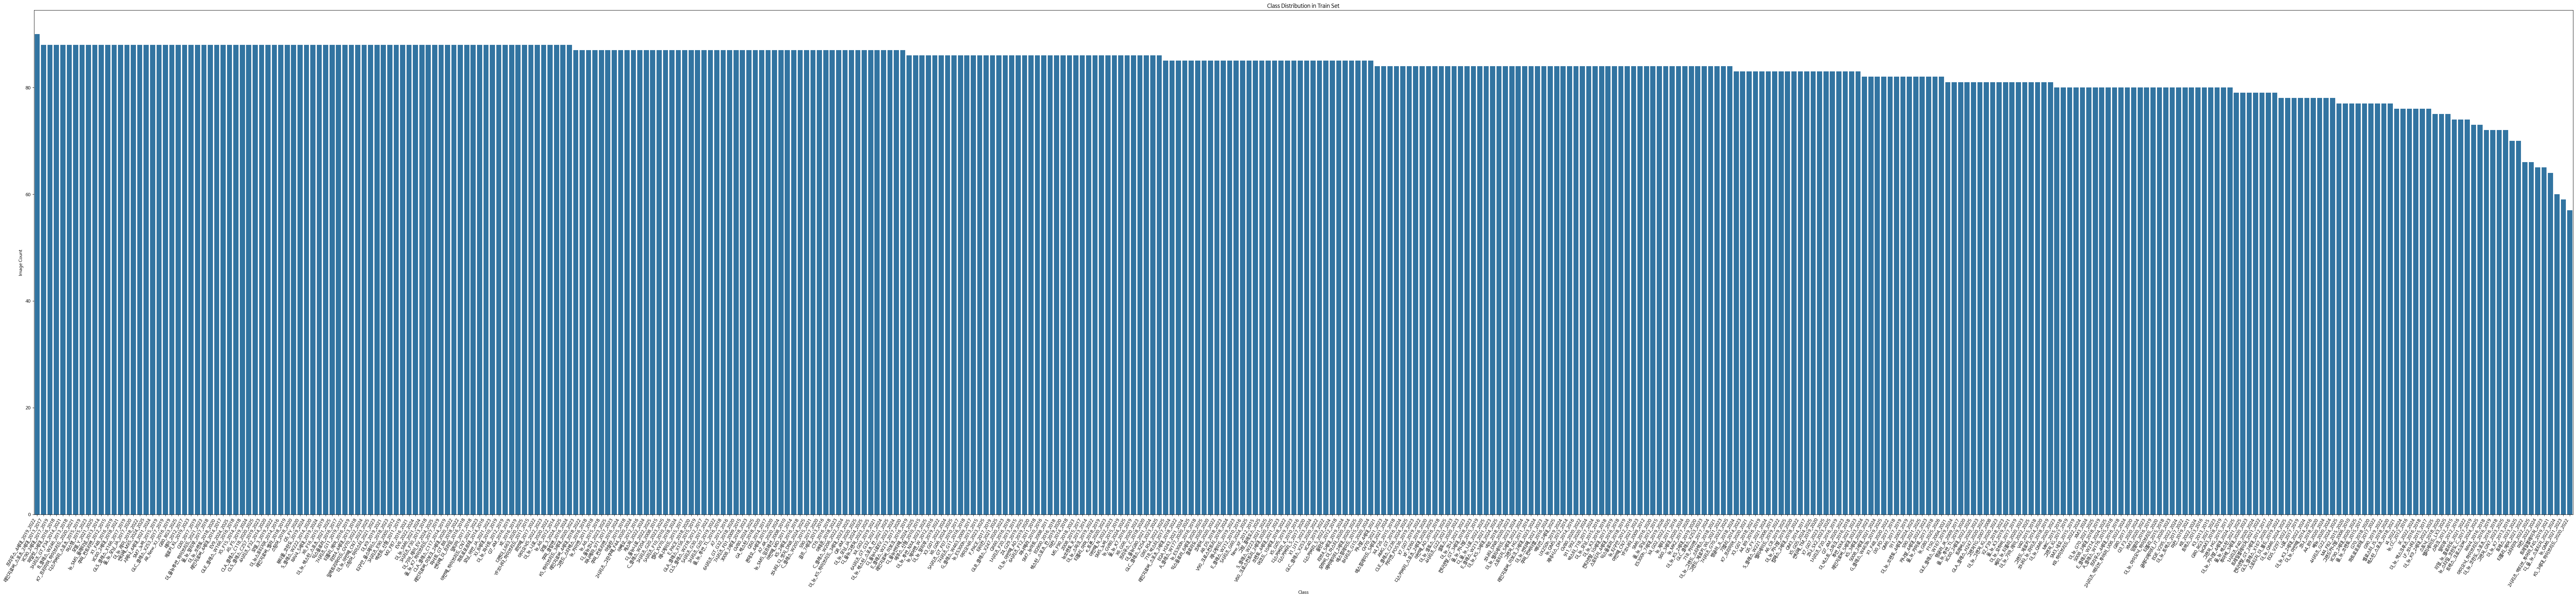

In [43]:
plt.figure(figsize=(100, 20))
sns.countplot(x=train_df['class'], order=train_df['class'].value_counts().index)

plt.title("Class Distribution in Train Set")
plt.xlabel("Class")
plt.ylabel("Image Count")

plt.xticks(rotation=60, ha='right')
plt.show()

In [44]:
class_ratio = max(train_df['class'].value_counts()) / min(train_df['class'].value_counts())
class_ratio

1.5789473684210527

##### 1.0 ~ 1.5	⚪ 균형 (balanced)
##### 1.5 ~ 3.0	🟡 경미한 불균형 (mild imbalance)
##### 3.0 ~ 10.0	🟠 중간 불균형 (moderate)
##### > 1.57	🟡 경미한 불균형 (mild imbalance)

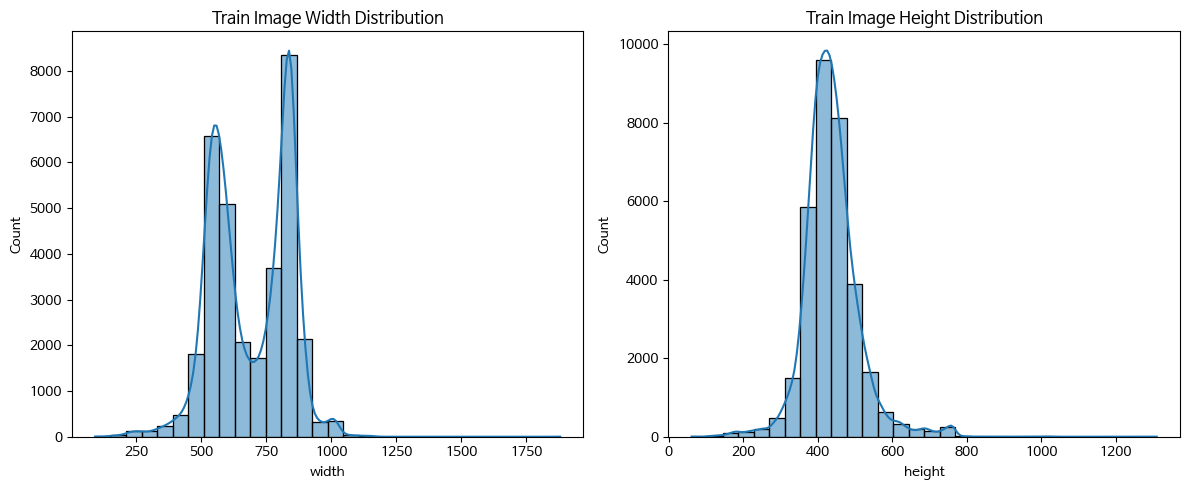

In [53]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['width'], bins=30, kde=True)
plt.title("Train Image Width Distribution")

plt.subplot(1, 2, 2)
sns.histplot(train_df['height'], bins=30, kde=True)
plt.title("Train Image Height Distribution")
plt.tight_layout()
plt.show()

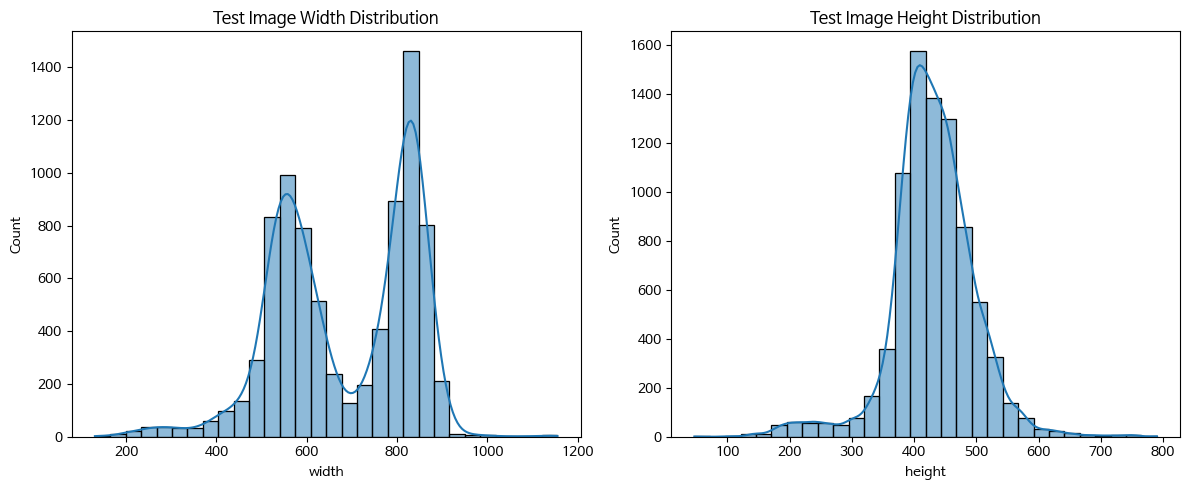

In [54]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(test_df['width'], bins=30, kde=True)
plt.title("Test Image Width Distribution")

plt.subplot(1, 2, 2)
sns.histplot(test_df['height'], bins=30, kde=True)
plt.title("Test Image Height Distribution")
plt.tight_layout()
plt.show()

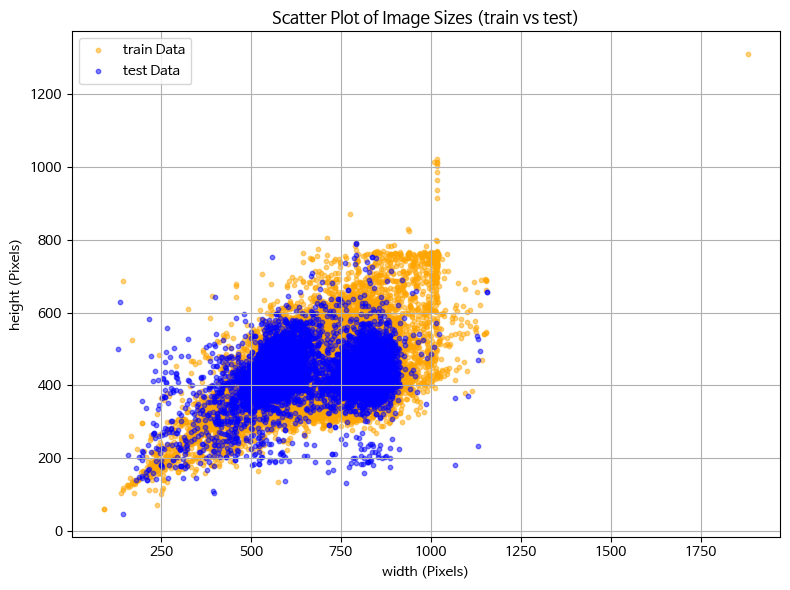

In [52]:
plt.figure(figsize=(8, 6))
colors = {'train': 'orange', 'test': 'blue'}
for label in all_df['type'].unique():
    subset = all_df[all_df['type'] == label]
    plt.scatter(subset['width'], subset['height'], label=f"{label} Data", alpha=0.5, s=10, c=colors[label])

plt.title("Scatter Plot of Image Sizes (train vs test)")
plt.xlabel('width (Pixels)')
plt.ylabel('height (Pixels)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Train 데이터는 다소 다양하지만 분포가 자연스로움
##### 정비례 패턴 -> aspect ratio 가 일정, 
##### Resize or Resize + Padding 전략에 유리

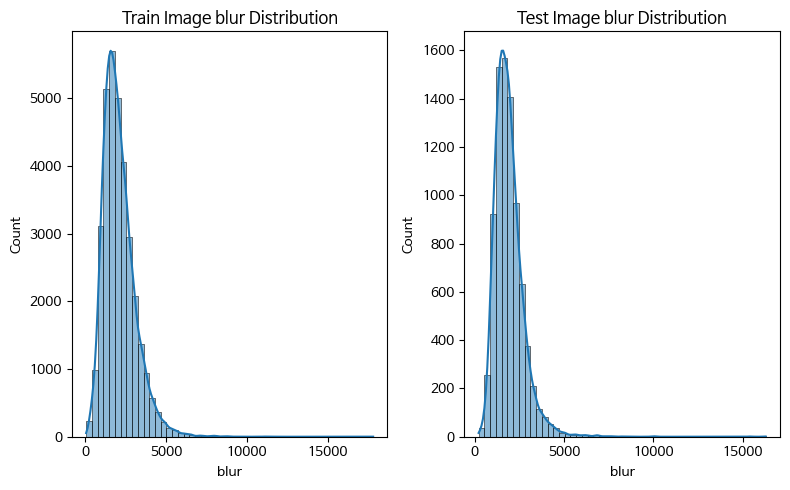

In [115]:
plt.figure(figsize=([8, 5]))
plt.subplot(1, 2, 1)
sns.histplot(train_df['blur'], bins=50, kde=True)
plt.title('Train Image blur Distribution')

plt.subplot(1, 2, 2)
sns.histplot(test_df['blur'], bins=50, kde=True)
plt.title('Test Image blur Distribution')
plt.tight_layout()
plt.show()

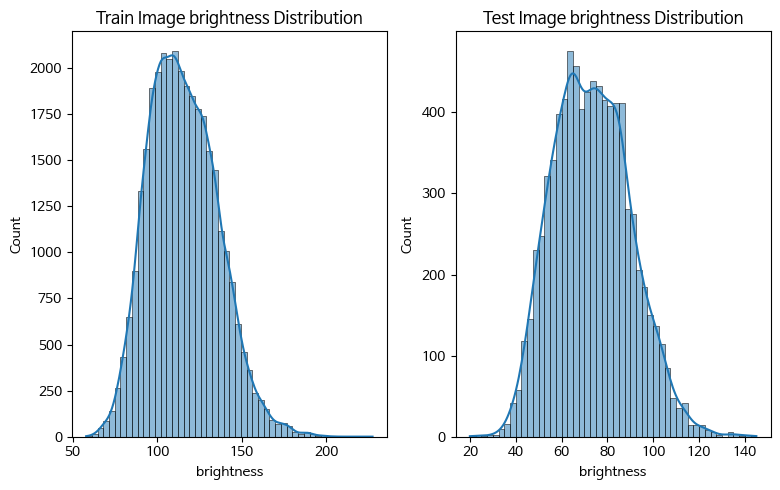

In [116]:
plt.figure(figsize=([8, 5]))
plt.subplot(1, 2, 1)
sns.histplot(train_df['brightness'], bins=50, kde=True)
plt.title('Train Image brightness Distribution')

plt.subplot(1, 2, 2)
sns.histplot(test_df['brightness'], bins=50, kde=True)
plt.title('Test Image brightness Distribution')
plt.tight_layout()
plt.show()

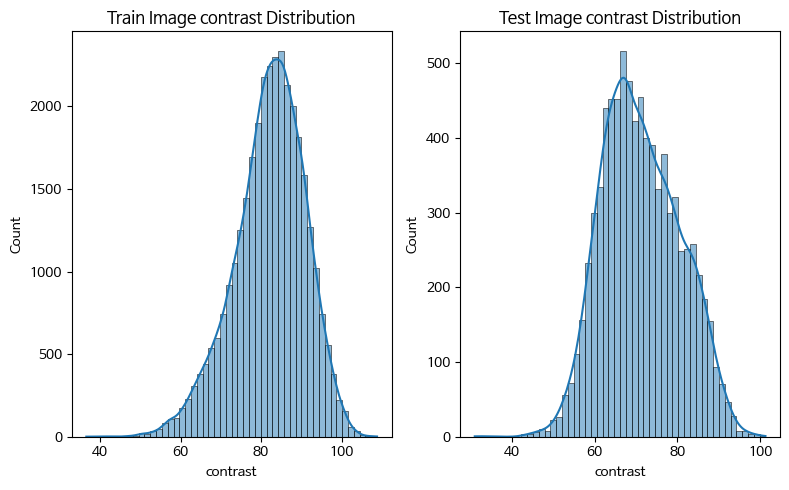

In [117]:
plt.figure(figsize=([8, 5]))
plt.subplot(1, 2, 1)
sns.histplot(train_df['contrast'], bins=50, kde=True)
plt.title('Train Image contrast Distribution')

plt.subplot(1, 2, 2)
sns.histplot(test_df['contrast'], bins=50, kde=True)
plt.title('Test Image contrast Distribution')
plt.tight_layout()
plt.show()

### blur의 분포는 Train, Test 동일
### brightness 의 분포는 Train이 20~30 정도 높음
### contrast의 분포는 Train이 10~20 정도 높음